In [2]:
from pathlib import Path

import pandas as pd
from pandas.errors import EmptyDataError 

import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta, timezone
from datetime import date as dt
import dateutil.parser as dparser
import dateutil.tz as tzinfo
import pytz

In [32]:
# Given parameters:
# 1) Date in the form (YYYYMMDD)
# 2) Time in the form (HHMMSS)
# 4) det_type can either be 'LF' or 'HF'

# Output:
# The table of selections. 
# - Column 1 is start time of selection within file
# - Column 2 is end time of selection within file
# - Column 3 is lowest frequency of selection within file
# - Column 3 is highest frequenct of selection within file
# Length of selections will give us # of selections

def read_detection(date, time, det_type):
    source_dir = f"detections/{date}/{date}_{det_type}detections"

    file_name = f"{det_type}_{date}_{time}.WAV.txt"
    file_path = f"{source_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        try:
            df_detection = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(f"{file_path} is empty")
            
    return df_detection

In [33]:
# These are variables that will help us point to specific folders and files

# detection_dir is the folder name where our detections are.
# This is an attempt to make code independent of the existence of recordings
# and only relying on the batch detection files.
date = "20220723"
detection_dir = f"/home/adkris1002/RavenPro1.6/Selections/{date}/{date}_HFdetections"

# Construct path object linked to the directory of files for datetime-parsing
file_dir = Path(detection_dir)
sorted_files = sorted(list(file_dir.iterdir()))

audio_dur = timedelta(minutes=29, seconds=55)

# We fill the first 3 columns of our dataframe right here using dateutils parser
dates = []
s_times = []
e_times = []
# We fill out the next 2 columns of data regarding the number of LF and HF selections
num_LFdetections = np.zeros(len(sorted_files))
num_HFdetections = np.zeros(len(sorted_files))

2022-07-23 00:00:00


In [34]:
for i, file in enumerate(sorted_files):
    file_name = file.name
    file_info = dparser.parse(file_name, fuzzy=True)
    
    date = str(file_info.date())
    s_time = str(file_info.time())
    e_time = str((file_info + audio_dur).time())
    
    dates.append(date)
    s_times.append(s_time)
    e_times.append(e_time)
    
    # We need to remove the - from YYYY-MM-DD which is standard datetime format.
    # This will help us find files in the YYYYMMDD standard Audiomoth format
    date = date.replace('-', '')
    # Same goes for the HH:MM:SS standard datetime format and the Audiomoth's HHMMSS standard
    time = s_time.replace(":", "")
    
    LFfile_detections = read_detection(date, time, 'LF')
    num_LFdetections[i] = LFfile_detections.shape[0]/2
    
    HFfile_detections = read_detection(date, time, 'HF')
    num_HFdetections[i] = HFfile_detections.shape[0]/2

In [35]:
df = pd.DataFrame()

df["File Names"] = sorted_files
df["Date"] = dates  
df["Start Time (UTC)"] = s_times
df["End Time (UTC)"] = e_times
df["# of LF detections"] = num_LFdetections
df["# of HF detections"] = num_HFdetections

df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,00:00:00,00:29:55,0.0,0.0
1,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,00:30:00,00:59:55,0.0,0.0
2,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,01:00:00,01:29:55,0.0,0.0
3,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,01:30:00,01:59:55,0.0,0.0
4,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,02:00:00,02:29:55,0.0,0.0
5,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,02:30:00,02:59:55,0.0,0.0
6,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,03:00:00,03:29:55,0.0,0.0
7,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,03:30:00,03:59:55,0.0,0.0
8,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,04:00:00,04:29:55,0.0,41.0
9,/home/adkris1002/RavenPro1.6/Selections/202207...,2022-07-23,04:30:00,04:59:55,5.0,1127.0


<AxesSubplot:xlabel='Start Time (UTC)'>

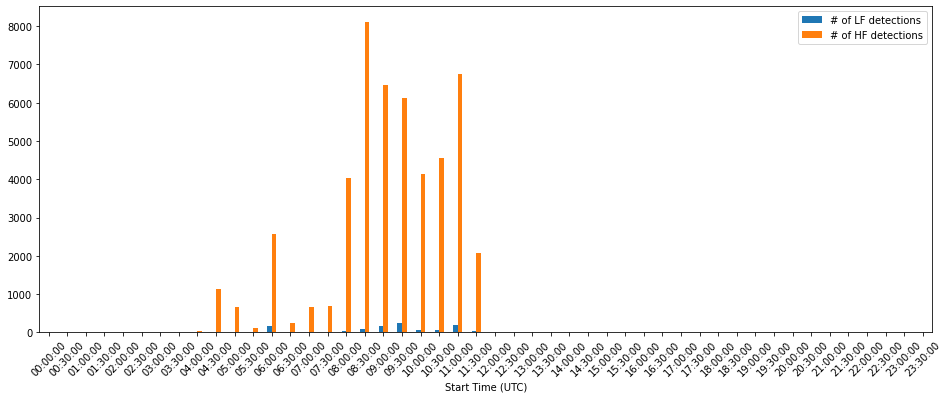

In [36]:
df.plot.bar(x="Start Time (UTC)", figsize=(16, 6), rot=45)